In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb

In [ ]:
cols = open("census-bureau.columns").read().splitlines()
cols

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'wage per hour',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 "fill inc questionnaire for veteran's admin"

In [ ]:
df = pd.read_csv('census-bureau.data', sep=',', names=cols)
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [ ]:
df['label'].value_counts()/len(df) # check class balance: <50000 is majority class

,count
label,
- 50000.,0.937942
50000+.,0.062058


In [ ]:
df = df.assign(encode_label = (df['label']!='- 50000.').astype(int)) # encode target label that <50000 as 0, >50000 as 1

,weight
count,199523.000000
mean,1740.380269
std,993.768156
min,37.870000
25%,1061.615000
50%,1618.310000
75%,2188.610000
max,18656.300000


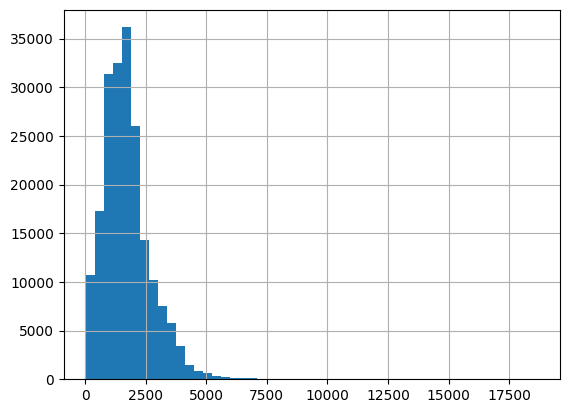

In [ ]:
df['weight'].hist(bins=50)
df['weight'].describe() # weight is right skewed, with some outliers.


In [ ]:
df.select_dtypes(include='number').columns

Index(['age', 'detailed industry recode', 'detailed occupation recode',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'weight', 'num persons worked for employer',
       'own business or self employed', 'veterans benefits',
       'weeks worked in year', 'year', 'encode_label'],
      dtype='object')

In [ ]:
df.isna().sum() # hispanic origin has 874 na

,0
age,0
class of worker,0
detailed industry recode,0
detailed occupation recode,0
education,0
wage per hour,0
enroll in edu inst last wk,0
marital stat,0
major industry code,0
major occupation code,0


In [ ]:
df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')

In [ ]:
df['citizenship'].value_counts() # 0 is majority class, only 7% of data is self-employed.

,count
citizenship,
Native- Born in the United States,176992
Foreign born- Not a citizen of U S,13401
Foreign born- U S citizen by naturalization,5855
Native- Born abroad of American Parent(s),1756
Native- Born in Puerto Rico or U S Outlying,1519


In [ ]:
categorical_cols=['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', # have region of previous residence
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother','country of birth self',
       'citizenship',
       'fill inc questionnaire for veteran\'s admin',
       'detailed industry recode', 'detailed occupation recode',
       'own business or self employed', 'veterans benefits', 'year']

In [ ]:
df[categorical_cols].nunique().sort_values(ascending=False)

,0
detailed industry recode,52
state of previous residence,51
detailed occupation recode,47
detailed household and family stat,36
major industry code,24
education,17
major occupation code,15
migration code-change in msa,10
migration code-move within reg,10
detailed household summary in household,9


In [ ]:
numerical_cols=['age',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'num persons worked for employer',
       'weeks worked in year']
# 'weight' is removed from feature, used as sampling weight during training
categorical_cols=['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
      #  'state of previous residence', # have region of previous residence
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
      #  'country of birth father', 'country of birth mother','country of birth self',
       'citizenship',
       'fill inc questionnaire for veteran\'s admin',
       'detailed industry recode', 'detailed occupation recode',
       'own business or self employed', 'veterans benefits', 'year']


In [ ]:
df[categorical_cols] = df[categorical_cols].astype('category')

In [ ]:
X = df.drop(columns=['label', 'encode_label'])
y = df['encode_label']
weights = df['weight']

In [ ]:
# split data
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2,
                                                                  stratify=y)  # preserves class distribution
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(127694, 41) (31924, 41) (39905, 41)


# Exploratory Data Analysis

<Axes: xlabel='citizenship'>

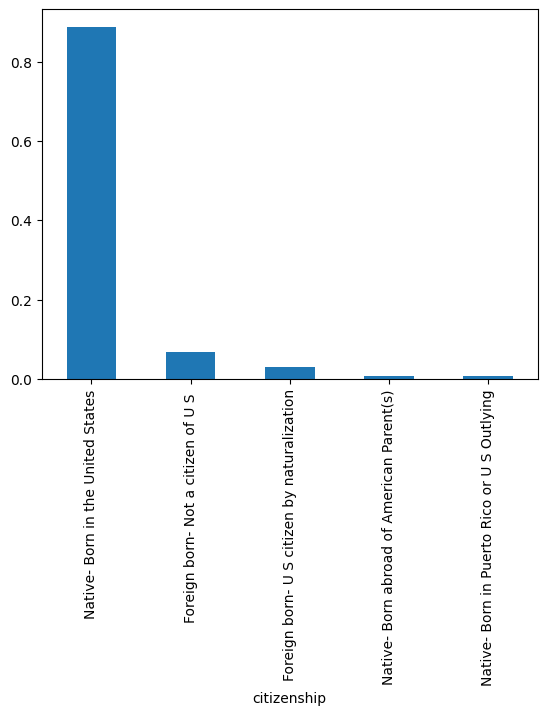

In [ ]:
df['citizenship'].value_counts(normalize=True).plot(kind='bar')

<Axes: >

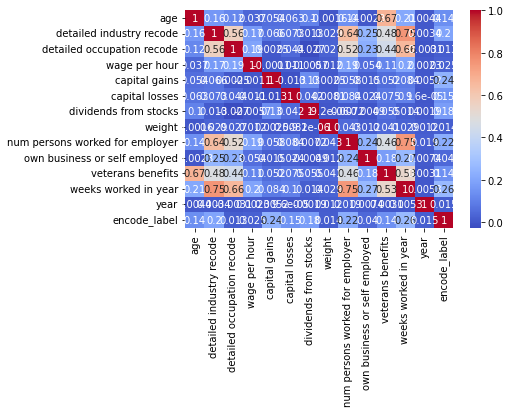

In [ ]:
import seaborn as sns
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm')

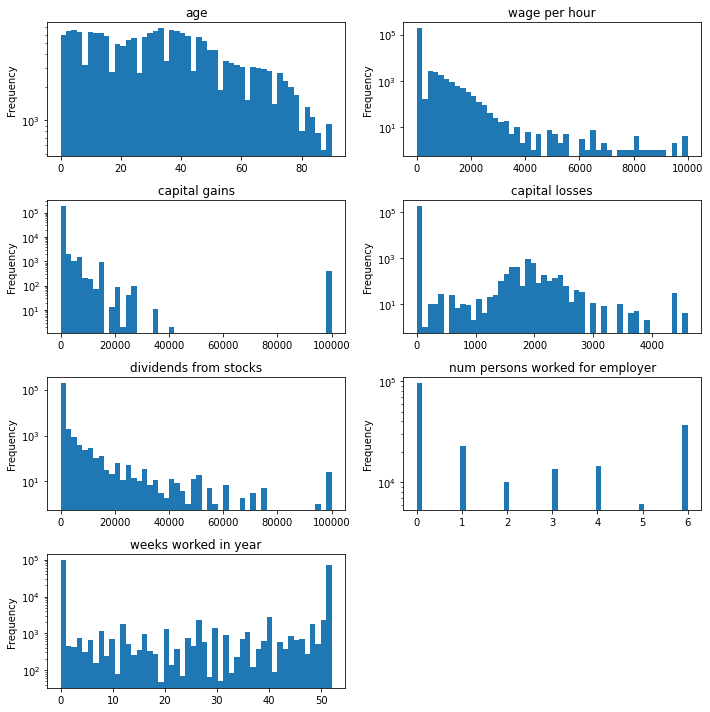

In [ ]:
figure, axes = plt.subplots(4,2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, numerical_cols):
    df[col].plot.hist(bins=50, ax=ax, logy=True) # use log scale for better visualization of skewed distributions
    ax.set_title(col)
# turn off any unused subplots
for ax in axes[len(numerical_cols):]:
    ax.axis('off')#

plt.tight_layout()
plt.show()

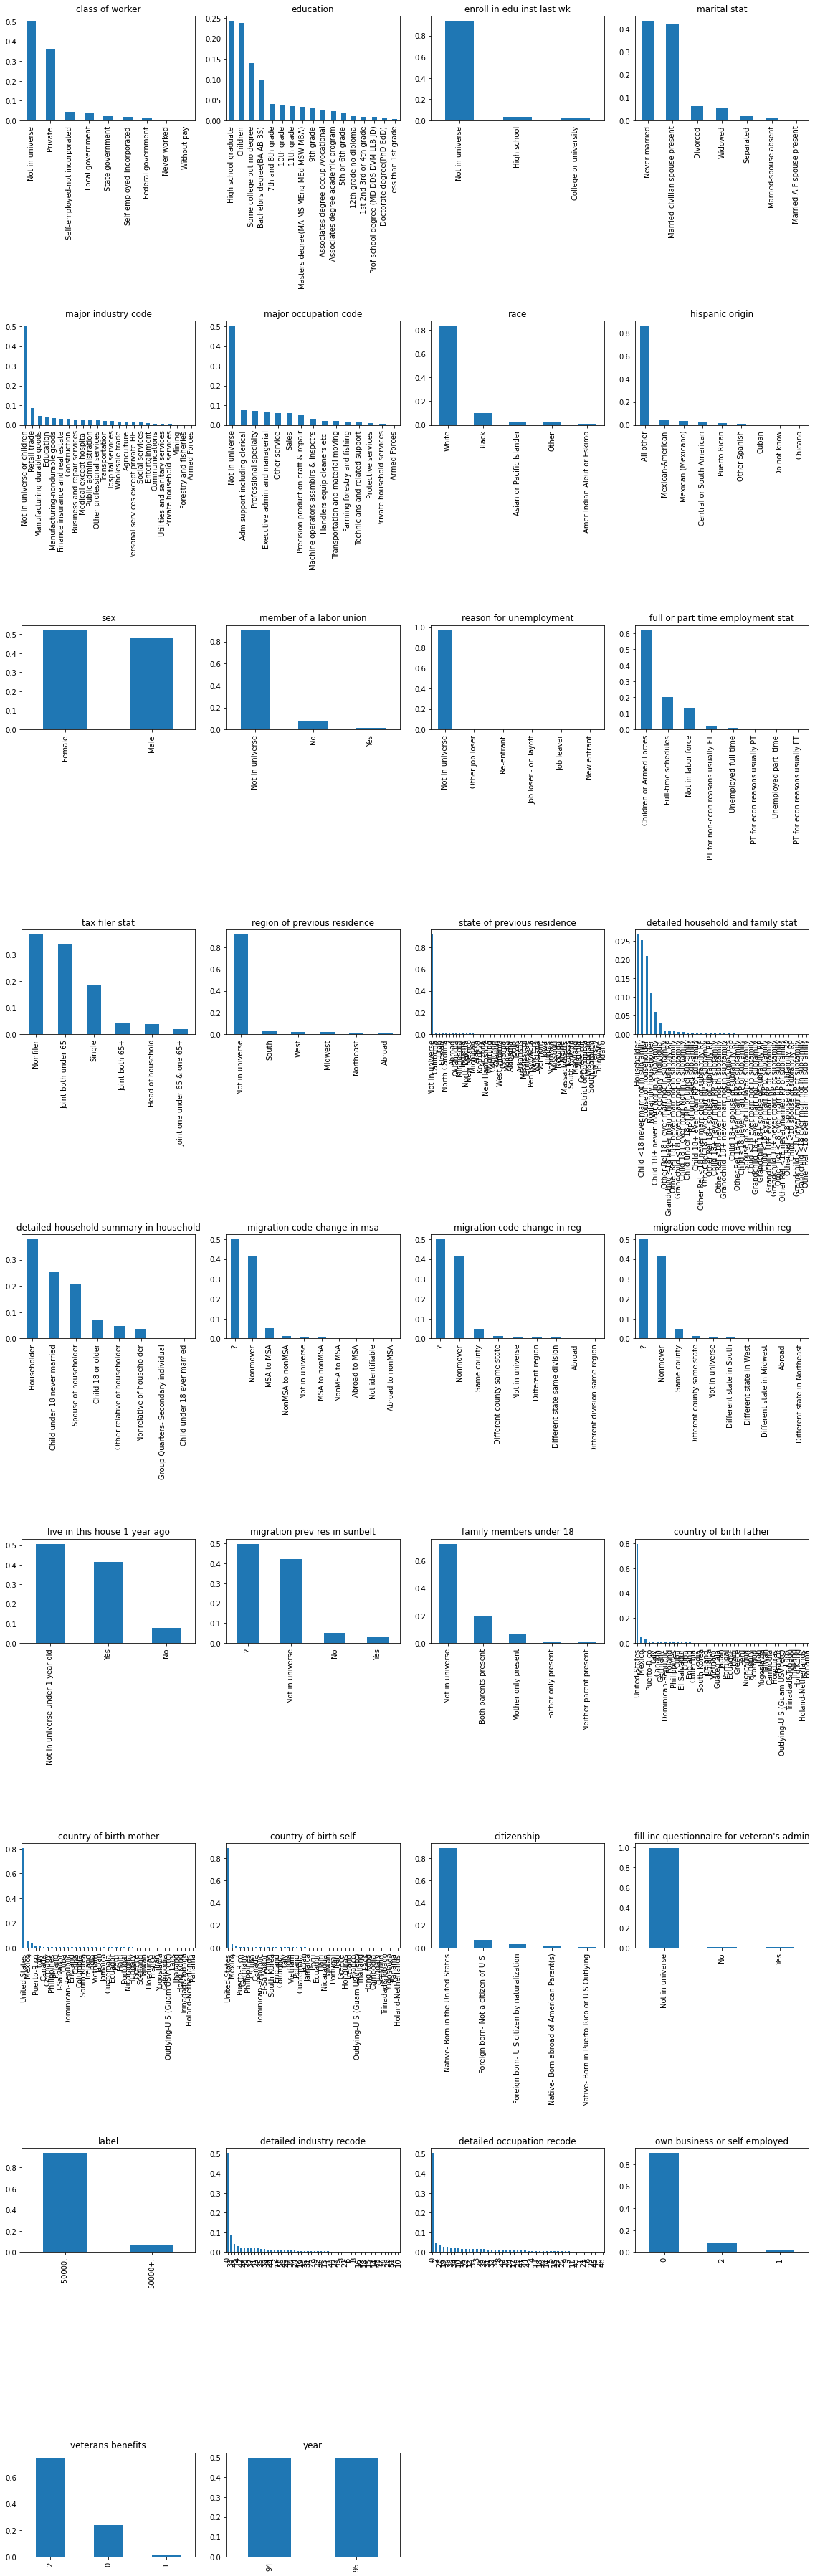

In [ ]:
figure, axes = plt.subplots(9,4, figsize=(16,50))
axes = axes.flatten()
for ax, col in zip(axes, categorical_cols):
    df[col].value_counts(normalize=True).plot.bar(ax=ax)
    ax.set_title(col)
# turn off any unused subplots
for ax in axes[len(categorical_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Feature Engineering

In [ ]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
])

In [ ]:
X_train_processed = preprocess.fit_transform(X_train)

In [ ]:
X_val_processed = preprocess.transform(X_val)
X_test_processed = preprocess.transform(X_test)

In [ ]:
X_train_processed.shape

(127694, 328)

# Income Type Classification

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [ ]:
lg = LogisticRegression(class_weight='balanced', penalty='l1',solver='saga', max_iter=1000, n_jobs=-1)
# since we have a lot of one-hot-encoded features, so soarce data. 'sage' suitable for sparse data and l1 penalty for feature selection
lg.fit(X_train_processed, y_train) # remove sample_weights

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   penalty='l1', solver='saga')

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
lg_val_pred = lg.predict(X_val_processed)
lg_val_precision = precision_score(y_val, lg_val_pred)
print(lg_val_precision)

0.2863233847163004


In [ ]:
lg_val_recall = recall_score(y_val, lg_val_pred)
print(lg_val_recall)

0.8926380368098159


In [ ]:
print(classification_report(y_val, lg_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     29968
           1       0.29      0.89      0.43      1956

    accuracy                           0.86     31924
   macro avg       0.64      0.87      0.68     31924
weighted avg       0.95      0.86      0.89     31924



In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

lg_val_y_prob = lg.predict_proba(X_val_processed)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, lg_val_y_prob)
pr_auc = auc(recall, precision) # Note: x is recall, y is precision
print('Validation PR-AUC: ', pr_auc)

Validation PR-AUC:  0.6034550449446352


In [ ]:
# optimize f2 score
from sklearn.metrics import fbeta_score

lg_val_y_proba = lg.predict_proba(X_val_processed)[:, 1]

thresholds = np.linspace(0, 1, 100)
f2_scores = []

for t in thresholds:
    y_pred = (lg_val_y_proba >= t).astype(int)
    f2_scores.append(fbeta_score(y_val, y_pred, beta=2))

best_threshold = thresholds[np.argmax(f2_scores)]
print("Best threshold:", best_threshold)

Best threshold: 0.6161616161616162


In [ ]:
lg_test_y_prob = lg.predict_proba(X_test_processed)[:,1]
lg_test_pred=(lg_test_y_prob>=best_threshold).astype(int)
print(classification_report(y_test, lg_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     37429
           1       0.35      0.84      0.49      2476

    accuracy                           0.89     39905
   macro avg       0.67      0.87      0.72     39905
weighted avg       0.95      0.89      0.91     39905



In [ ]:
from xgboost import XGBClassifier

In [ ]:

xgb = XGBClassifier(
    scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train),
    eval_metric="logloss",
    tree_method="hist"
)

In [ ]:
xgb.fit(X_train_processed, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
xgb_val_pred = xgb.predict(X_val_processed)

In [ ]:
print(classification_report(y_val, xgb_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     29968
           1       0.34      0.84      0.49      1956

    accuracy                           0.89     31924
   macro avg       0.67      0.87      0.71     31924
weighted avg       0.95      0.89      0.91     31924



In [ ]:
xgb_test_pred = xgb.predict(X_test_processed)
print(classification_report(y_test, xgb_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     37429
           1       0.34      0.83      0.48      2476

    accuracy                           0.89     39905
   macro avg       0.66      0.86      0.71     39905
weighted avg       0.95      0.89      0.91     39905



In [ ]:
xgb2 = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    # subsample=0.8,
    # colsample_bytree=0.8,
    # min_child_weight=5,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
    eval_metric='aucpr',
)

In [ ]:
xgb2.fit(X_train_processed, y_train, sample_weight=w_train)
xgb_val_pred = xgb2.predict(X_val_processed)
print(classification_report(y_val, xgb_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     29968
           1       0.32      0.88      0.47      1956

    accuracy                           0.88     31924
   macro avg       0.66      0.88      0.70     31924
weighted avg       0.95      0.88      0.90     31924



In [ ]:
lg_val_y_prob = xgb2.predict_proba(X_val_processed)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, lg_val_y_prob)
pr_auc = auc(recall, precision)
print('Validation PR-AUC for XGBoost: ', pr_auc)

Validation PR-AUC for XGBoost:  0.6644422609928141


In [ ]:
xgb_test_pred = xgb2.predict(X_test_processed)
print(classification_report(y_test, xgb_test_pred))
xgb_test_proba = xgb2.predict_proba(X_test_processed)[:,1]
print('Test PR-AUC for XGBoost: ', average_precision_score(y_test, xgb_test_proba))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     37429
           1       0.32      0.87      0.47      2476

    accuracy                           0.88     39905
   macro avg       0.66      0.88      0.70     39905
weighted avg       0.95      0.88      0.90     39905

Test PR-AUC for XGBoost:  0.6705079276031887
